In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Project Overview: Genetic Variation Analysis Across Populations

In this project, I analyzed genomic data focusing on SNPs (Single Nucleotide Polymorphisms), which represent variations at a single position in the DNA sequence among individuals.

Each SNP can contain one of four possible nucleotides: A, C, G, or T. For example, a SNP labeled `rs33` located at position 11 on a chromosome may have A as the reference allele and T as the alternative allele. Different populations may show different frequencies of these alleles.

Understanding these variations is crucial for:
- Identifying population-specific traits
- Studying genetic diversity
- Supporting clinical applications such as personalized medicine and genetic testing

To conduct this analysis, I used a dataset containing:
- **Geno matrix**: 20,000 SNPs (columns) measured across 777 individuals (rows). Each entry represents the number of copies of the reference allele (0, 1, or 2).
- **Population labels (`ind`)**: Each individual is labeled as French, Turkish, Spanish, or Others.
- **SNP names (`snp`)**: The identifiers for each SNP marker.

The goal was to investigate differences in allele frequencies across modern populations, with a specific focus on comparing the **French**, **Turkish**, and **Spanish** groups. This type of analysis helps in identifying regions of the genome with high variation across populations, potentially reflecting adaptation, ancestry, or population history.


In [3]:
geno_path = '/content/drive/My Drive/geno'
ind_path = '/content/drive/My Drive/ind'
snp_path = '/content/drive/My Drive/snp'

geno_df = pd.read_csv(geno_path, header=None, sep=',')
ind_df = pd.read_csv(ind_path, header=None, sep=',', names=['ID', 'Gender', 'Population'])
snp_df = pd.read_csv(snp_path, header=None, sep=',', names=['SNP', 'CHROM', 'REF_ALLELE', 'ALT_ALLELE'])

indep_var = geno_df.shape[1]
observ = geno_df.shape[0]
num_rows, num_columns = geno_df.shape
print(f"\nThe 'geno' data frame has {num_rows} rows and {num_columns} columns.")



The 'geno' data frame has 777 rows and 20000 columns.


## Filtering and Visualizing Population Distribution

To begin the analysis, I merged the genotype matrix (`geno_df`) with the population metadata (`ind_df`) into a single DataFrame using.
This allowed each row to represent a single individual, including both their population label and their corresponding SNP data.

Next, I filtered the data to include only individuals from the three populations of interest — French, Turkish, and Spanish — as well as those labeled as Unknown.
To visualize the distribution of individuals across these populations, I used a count plot.

<ipython-input-6-1737446a62fc>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filtered_df, x='Population', palette='Set2', order=populations_of_interest)


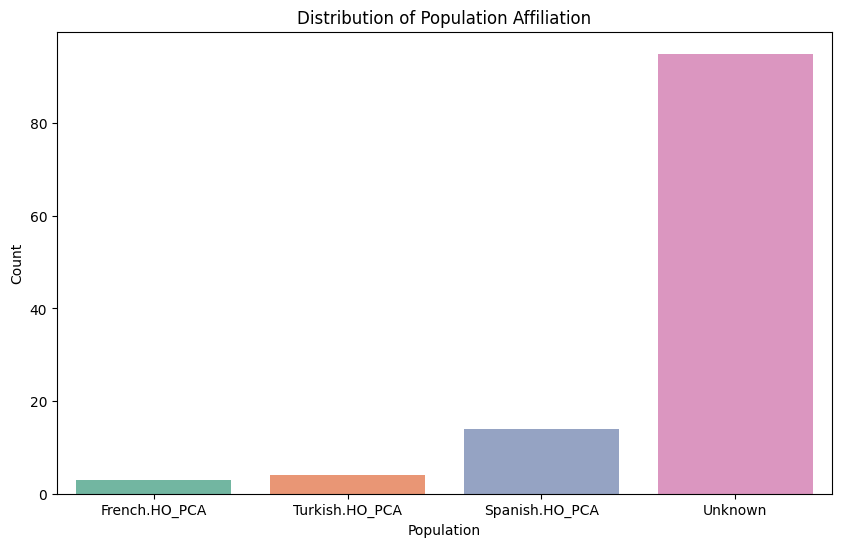

In [6]:
# Combine the geno and ind data frames
combined_df = pd.concat([ind_df, geno_df], axis=1)
populations_of_interest = ['French.HO_PCA', 'Turkish.HO_PCA', 'Spanish.HO_PCA', 'Unknown']
filtered_df = combined_df[combined_df['Population'].isin(populations_of_interest)]

plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_df, x='Population', palette='Set2', order=populations_of_interest)
plt.title('Distribution of Population Affiliation')
plt.xlabel('Population')
plt.ylabel('Count')
plt.show()

## Checking for Variation Across SNPs and the Need for Normalization

Before applying dimensionality reduction techniques such as SVD (Singular Value Decomposition), I examined whether the SNP features vary across individuals.

To determine whether any explanatory variables should be removed from the analysis, you I considered the following criteria:

1. Low Variance: very little variation across individuals provide little information and can be removed.
2. Missing Data: high percentage of missing values might need to be excluded or imputed.

In [7]:
# Calculate the variance for each SNP
variances = geno_df.var()

# Threshold for low variance
variance_threshold = 0.01

# Identify SNPs with low variance
low_variance_snps = variances[variances < variance_threshold].index.tolist()
print(f"Number of SNPs with low variance: {len(low_variance_snps)}")

# Check for missing data in each SNP
missing_data = geno_df.isnull().sum()
missing_data_snps = missing_data[missing_data > 0].index.tolist()
print(f"Number of SNPs with missing data: {len(missing_data_snps)}")

# remove the identified SNPs from the geno_df
geno_df_cleaned = geno_df.drop(columns=low_variance_snps + missing_data_snps)

# Display the cleaned data frame's shape
print(f"Shape of the cleaned geno data frame: {geno_df_cleaned.shape}")


Number of SNPs with low variance: 2567
Number of SNPs with missing data: 0
Shape of the cleaned geno data frame: (777, 17433)


## Normalizing the Genotype Data

To prepare the SNP data for dimensionality reduction and downstream analysis, I normalized the genotype matrix using **z-score standardization**. This step ensures that all SNP features contribute equally to the analysis, regardless of their original scale or variance.

The normalization process was performed using `StandardScaler` from `sklearn.preprocessing`, which transforms each feature to have a mean of 0 and a standard deviation of 1.

This normalized dataset was then ready for further analysis, such as applying dimensionality reduction techniques like SVD or PCA.

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
geno_df_normalized = scaler.fit_transform(geno_df_cleaned)

# Convert back to DataFrame for convenience
geno_df_normalized = pd.DataFrame(geno_df_normalized, columns=geno_df_cleaned.columns)

# Display the first few rows of the normalized data frame
print(geno_df_normalized.head())

      0         1         2         3         4         5         6      \
0  0.213917 -0.385252 -2.068640 -0.506622 -0.404030  1.200497 -1.263484   
1  0.213917 -0.385252  0.964064 -0.506622 -0.404030 -0.219269 -1.263484   
2  0.213917 -0.385252 -2.068640 -0.506622  1.062938 -0.219269 -1.263484   
3  0.213917 -0.385252  0.964064 -0.506622 -0.404030  1.200497  0.624453   
4  0.213917 -0.385252  0.964064 -0.506622  1.062938  1.200497  0.624453   

      8         9         10     ...     19990     19991     19992     19993  \
0  0.158322 -0.727350 -0.922246  ...  0.458563  0.458563  0.458563  0.458563   
1  0.158322 -0.727350  0.732685  ...  0.458563  0.458563  0.458563  0.458563   
2  0.158322  0.934858  0.732685  ... -2.180724 -2.180724 -2.180724 -2.180724   
3  0.158322 -0.727350  0.732685  ... -2.180724 -2.180724 -2.180724 -2.180724   
4  0.158322  0.934858  0.732685  ...  0.458563  0.458563  0.458563  0.458563   

      19994     19995     19996     19997     19998     19999  
0  1

## Performing Truncated SVD on the Normalized Genotype Matrix

To reduce the dimensionality of the SNP dataset while preserving its essential structure, I applied **Truncated Singular Value Decomposition (Truncated SVD)** to the normalized genotype matrix.

Unlike full SVD, which computes all components, Truncated SVD focuses only on a subset of the most informative components. In this case, I extracted the top **2 components**, which capture the directions of greatest variance in the data.

The result of the decomposition includes:

- **U**: The projection of individuals into a 2D space (svd_result)

- **S**: The singular values representing the strength (variance explained) of each component

- **Vt**: The top right singular vectors, showing the contribution of each SNP feature to the components


This dimensionality reduction enables visualization of population structure and comparison of genetic variation across individuals in a simplified 2D space.

In [9]:
from sklearn.decomposition import TruncatedSVD

# Perform SVD
svd = TruncatedSVD(n_components=2)
svd_result = svd.fit_transform(geno_df_normalized)

# Get the components
U = svd_result
S = svd.singular_values_
Vt = svd.components_

# Convert the result to DataFrames for better understanding
U_df = pd.DataFrame(U, columns=['Component1', 'Component2'])
S_df = pd.DataFrame(S, columns=['SingularValues'])
Vt_df = pd.DataFrame(Vt, columns=geno_df_cleaned.columns)

# Display the dimensions of U, S, Vt
print(f"Dimensions of U: {U_df.shape}")
print(f"Dimensions of S: {S_df.shape}")
print(f"Dimensions of Vt: {Vt_df.shape}")


Dimensions of U: (777, 2)
Dimensions of S: (2, 1)
Dimensions of Vt: (2, 17433)


## Projecting Individuals onto the First Two Principal Components

After applying SVD, I used the resulting components to project each individual into a 2D space defined by the first two **principal components (PC1 and PC2)**. This projection captures the most significant axes of genetic variatio.

To visualize population-specific patterns in the reduced space, I merged the projection data with the population labels from `ind_df`.

I then filtered the dataset to include only the populations of interest — French, Turkish, and Spanish — for clearer interpretation.

A scatter plot was created to visualize the genetic structure of individuals in the 2D space defined by PC1 and PC2.

This plot helps identify clustering patterns or separations between populations, indicating underlying genetic structure. Finally, I confirmed the dimensionality of the projected data.

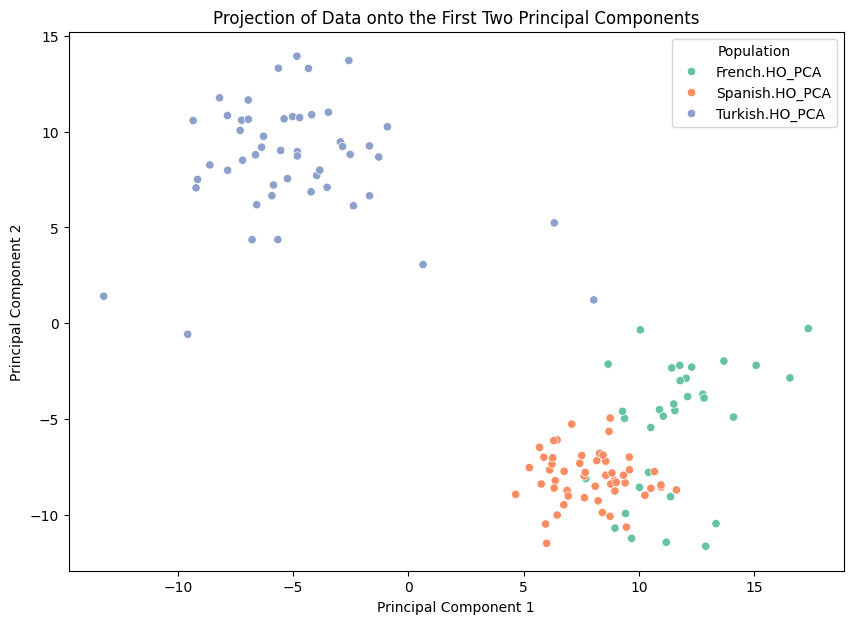

Dimension of each individual after projection: (777, 2)


In [10]:
#Project the data onto the first two PCs
# svd_result is the projection of the data onto the first two PCs
projection_df = pd.DataFrame(svd_result, columns=['PC1', 'PC2'])

# Merge with population data for visualization
projection_df = pd.concat([ind_df[['Population']], projection_df], axis=1)
populations_of_interest = ['French.HO_PCA', 'Turkish.HO_PCA', 'Spanish.HO_PCA']
filtered_projection_df = projection_df[projection_df['Population'].isin(populations_of_interest)]

# Step 4: Visualization (if desired)
plt.figure(figsize=(10, 7))
sns.scatterplot(data=filtered_projection_df, x='PC1', y='PC2', hue='Population', palette='Set2')
plt.title('Projection of Data onto the First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
print(f"Dimension of each individual after projection: {projection_df[['PC1', 'PC2']].shape}")

## Interpreting the Principal Component Projection

The scatter plot above displays individuals from three populations — **French**, **Spanish**, and **Turkish** — projected onto the first two principal components (PC1 and PC2). Each point represents an individual, and the clustering reveals patterns of genetic similarity.

### 1. French and Spanish Populations
- These two populations exhibit **partial overlap** in the 2D projection space.
- This overlap is expected, as both groups are from **Western Europe** and share **geographical proximity** and **historical ties**.
- However, clear differences still emerge, indicating the presence of **distinct genetic markers** in each population.

### 2. Turkish Population
- The Turkish individuals form a **separate and distinct cluster**, located in a different region of the plot.
- This separation suggests **unique genetic features** within the Turkish population.
- The distinction likely arises from **geographical distance**, as well as **historical and cultural factors** that shaped the region's genetic landscape.

This visualization confirms that the first two principal components effectively capture meaningful genetic variation across populations and support the identification of population structure.


## Evaluating the Explained Variance of Principal Components

To assess how much of the genetic variation is captured by the principal components, I performed PCA on the normalized genotype matrix using the maximum number of allowable components.

I then calculated the **cumulative explained variance**, which shows how much total variance is captured as more principal components are included. Then I ploted the cumulative explained variance.

Finally, I calculated how much variance is captured by the **first two principal components**, which were used in the earlier projection.

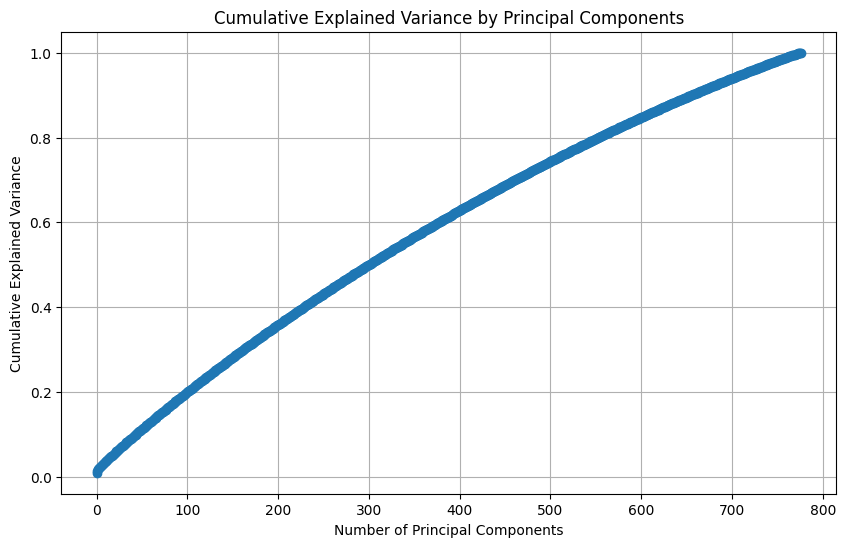

Variance explained by the first two components: 1.40%


In [12]:
from sklearn.decomposition import PCA
import numpy as np

# Step 1: Perform PCA with the maximum allowable number of components
pca = PCA(n_components=min(geno_df_normalized.shape))
pca.fit(geno_df_normalized)

# Step 2: Calculate Cumulative Explained Variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Step 3: Plot the Cumulative Explained Variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()
# Calculate the variance explained by the first two components
variance_first_two_components = sum(pca.explained_variance_ratio_[:2])
print(f"Variance explained by the first two components: {variance_first_two_components * 100:.2f}%")

## Interpretation
The first two components explained only **1.40%** of the total variance in the SNP data.
This result highlights that the **genetic variation is spread across many components**, and the projection onto two dimensions (as shown earlier) captures only a **very small portion** of the overall structure.

Despite this low percentage, the 2D projection was still effective in visually separating the populations. This is a common scenario in high-dimensional genetic data, where even small amounts of explained variance can reveal biologically meaningful population structures.

## Determining the Number of Components to Preserve 50% of the Variance

To determine how many principal components are needed to capture **at least 50%** of the variance in the SNP dataset, I searched for the smallest number of components for which the cumulative explained variance reaches or exceeds 0.50.

I then visualized this threshold on the cumulative explained variance plot using vertical and horizontal red lines to mark the point where 50% variance is reached.

The result showed that **301 principal components** are required to retain 50% of the original variance.

Number of components to explain 50% of the variance: 301


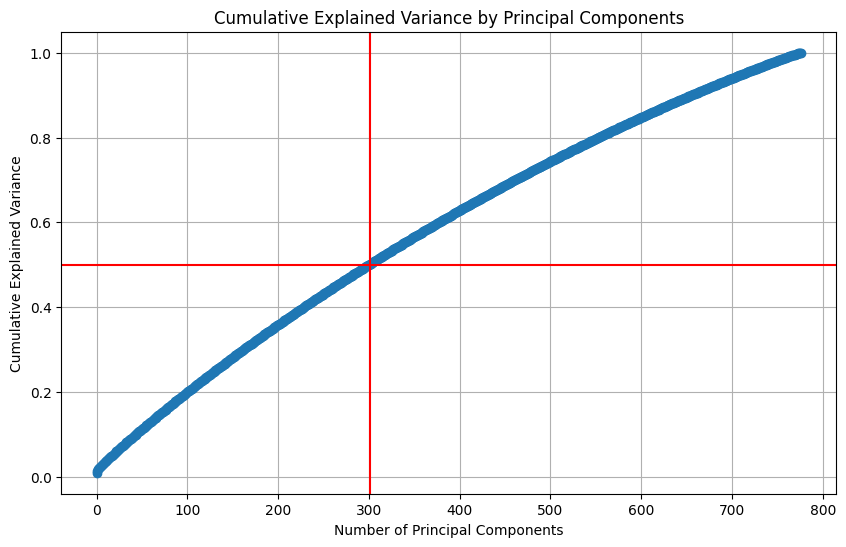

In [13]:
# Find the number of components to explain 50% of the variance
num_components_50_variance = np.argmax(cumulative_explained_variance >= 0.50) + 1
print(f"Number of components to explain 50% of the variance: {num_components_50_variance}")

# Plot the Cumulative Explained Variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.50, color='r', linestyle='-')
plt.axvline(x=num_components_50_variance, color='r', linestyle='-')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

##Data Reconstruction and Reconstruction Error
To evaluate how well the original data can be approximated using only 301 components, I performed the following steps:

1. **Transformed the data** into a 301-dimensional PCA space.
2. **Reconstructed the data** from the reduced components.
3. **Calculated the reconstruction error** using the Frobenius norm, which measures the difference between the original and reconstructed data matrices.

###Results
Number of components to reach 50% variance: 301

Reconstruction error: 2650.08 (Frobenius norm)

In [15]:
num_components = 301
pca = PCA(n_components=num_components)
reduced_data = pca.fit_transform(geno_df_normalized)

# Step 3: Reconstruct the data from the reduced components
reconstructed_data = pca.inverse_transform(reduced_data)

# Step 4: Calculate the reconstruction error (Frobenius norm)
reconstruction_error = np.linalg.norm(geno_df_normalized - reconstructed_data, 'fro')

# Print the reconstruction error
print(f"Reconstruction error (Frobenius norm): {round(reconstruction_error,2)}")

Reconstruction error (Frobenius norm): 2649.84
